In [1]:
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import PredictionError, residuals_plot
from sklearn.metrics import PredictionErrorDisplay

In [2]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.style.use('ggplot')

In [29]:
def print_evaluate(true, predicted):  
    
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def run_all_regressions(X_train, X_test, Y_train, Y_test):
    
    regs = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        'RandomForest': RandomForestRegressor()
    }

    for name, model in regs.items():

        model.fit(X_train, Y_train)
        
        print(f'\n-----{name}------')
        print('[Train] -------------')
        print_evaluate(Y_train, model.predict(X_train))

        print('[Test] --------------')
        print_evaluate(Y_test, model.predict(X_test))
        
        
def ApplyesKFold(x, y, k=5):
    
    kfold  = KFold(n_splits=k, shuffle=True, random_state=0)

    linearRegression = LinearRegression()
    elasticNet       = ElasticNet()
    ridge            = Ridge()
    lasso            = Lasso()
    rf               = RandomForestRegressor()
    ran_reg          = RANSACRegressor()


    linearRegression_result = cross_val_score(linearRegression, x, y, cv = kfold)
    elasticNet_result       = cross_val_score(elasticNet, x, y, cv = kfold)
    ridge_result            = cross_val_score(ridge, x, y, cv = kfold)
    lasso_result            = cross_val_score(lasso, x, y, cv = kfold)
    rf_result               = cross_val_score(rf, x, y, cv = kfold)
    ran_result              = cross_val_score(ran_reg, x, y, cv = kfold)

    dic_models = {
        "LinearRegression": linearRegression_result.mean(),
        "ElasticNet": elasticNet_result.mean(),
        "Ridge": ridge_result.mean(),
        "Lasso": lasso_result.mean(),
        "Random Forest": rf_result.mean(),
        "RANSAC": ran_result.mean()
    }
    
    bestModel = max(dic_models, key=dic_models.get)

    print("Linear Regression Mean (R^2): ", linearRegression_result.mean(), ' std: ',linearRegression_result.std())
    print("Elastic Net Mean (R^2): ", elasticNet_result.mean(), ' std: ', elasticNet_result.std())
    print("Ridge Mean (R^2): ", ridge_result.mean(), ' std: ', ridge_result.std())
    print("Lasso Mean (R^2): ", lasso_result.mean(), ' std: ', lasso_result.std())
    print("Random Forest Mean (R^2): ", rf_result.mean(), ' std: ', rf_result.std())
    print("RANSAC Mean (R^2): ", ran_result.mean(), ' std: ', ran_result.std())
                                                  
    print("\n Melhor modelo: {0} with value: {1}".format(bestModel, dic_models[bestModel]))
    
    
def apply_pca_reduce(data, n=None):
    
    scaler = StandardScaler()
    X = scaler.fit_transform(data)
    
    pca = PCA(n_components=data.shape[-1]).fit(X)
    
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    dim = np.argmax(cumsum >= 0.90) + 1
    
    print('Para preservar 90% da variance é necessário ' + str(dim))
        
    pca_refit = PCA(n_components=n if n else dim).fit(X)
    print('Ratio: ', pca_refit.explained_variance_ratio_)
    
    return pca_refit.transform(X)

In [4]:
weights = pd.read_csv("data/coletas/combined/annotations.csv")
features = pd.read_csv("features.csv")

In [5]:
weights.index = weights.img
features.index = features.label

weights = weights.drop('img', axis=1)
features = features.drop('label', axis=1)

In [6]:
data = pd.concat([weights, features],
                 axis=1,
                 ignore_index=False, 
                 verify_integrity=True)

data = data.reset_index()

In [7]:
data.head()

,index,specie,weight,width,length,area,bbox-0,bbox-1,bbox-2,bbox-3,...,moments_central-2-2,moments_central-2-3,moments_central-3-0,moments_central-3-1,moments_central-3-2,moments_central-3-3,orientation,perimeter,feret_diameter_max,solidity
0,IMG_20220110_150135.jpg,tambaqui,220,9.0,22,6265,80,29,150,162,...,9.451928e+08,-7.003478e+09,5.423848e+04,2.388364e+07,-5.789975e+07,-1.071610e+10,-1.555946,349.462987,134.495353,0.928148
1,IMG_20220110_150324.jpg,tilápia,545,11.0,26,10600,70,19,164,187,...,4.282950e+09,-1.349467e+10,-3.121288e+06,8.530533e+08,-1.098072e+09,7.798581e+11,1.526699,444.374675,168.428026,0.949566
2,IMG_20220110_150406.jpg,curimatã,1025,12.0,31,14170,57,5,164,203,...,1.093375e+10,2.184438e+10,3.606262e+07,-1.405601e+09,-3.543888e+10,-5.172718e+12,-1.491373,506.357431,199.007538,0.962898
3,IMG_20220110_150506.jpg,panga,740,10.0,37,9042,87,6,157,200,...,2.650567e+09,-4.582602e+09,-2.538047e+06,3.087611e+06,4.523251e+09,7.371602e+10,1.566756,467.847763,194.311605,0.929960
4,IMG_20220110_150552.jpg,tilápia,475,10.0,24,8624,73,16,156,165,...,2.356460e+09,-4.228981e+09,-1.981609e+06,4.478496e+08,9.458410e+08,4.923908e+11,1.506794,389.019336,149.482440,0.954299


In [8]:
data.specie.value_counts()

tambaqui    49
tilápia     25
curimatã    14
panga        7
traíra       3
lambari      2
Name: specie, dtype: int64

In [9]:
data.weight.sum() / 1000

50.913

In [10]:
data.weight /= 1000

In [14]:
enc = LabelEncoder()

In [15]:
data.specie = enc.fit_transform(data.specie.values)

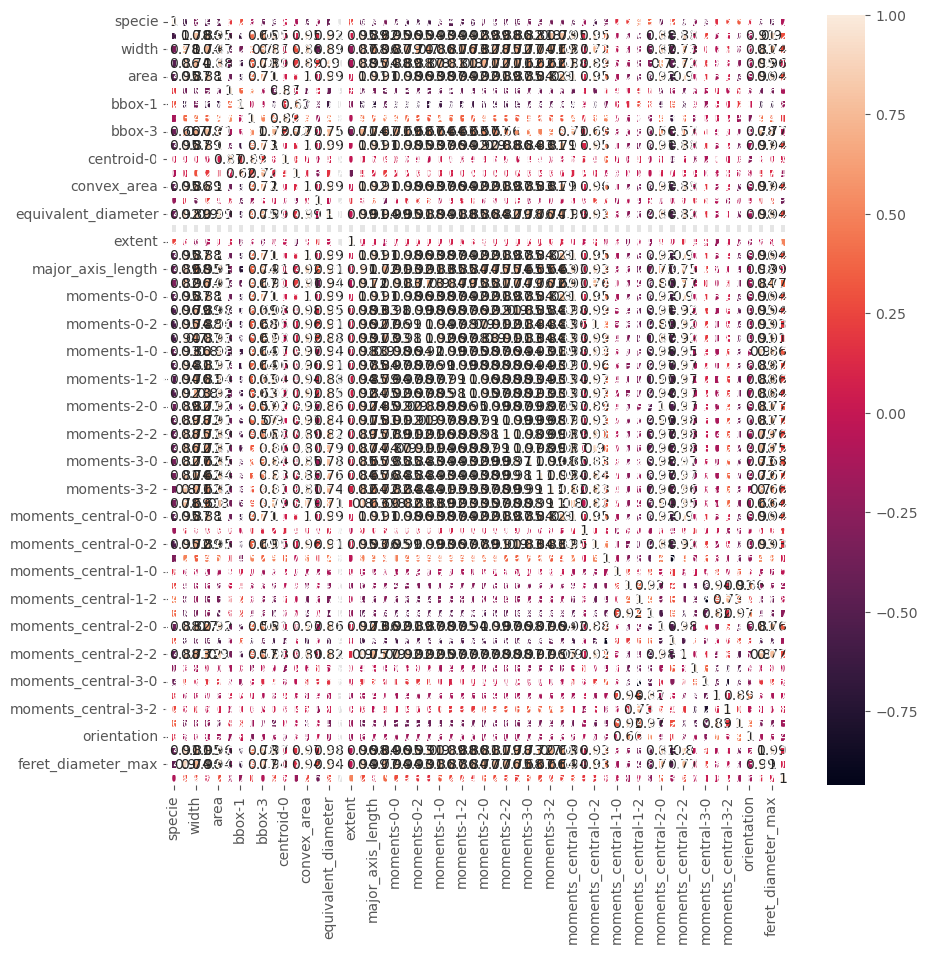

In [16]:
data_corr = data.drop(labels=['index'], axis=1)
corrmat = data_corr.corr()

_, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corrmat, linewidths=5, annot=True);

In [17]:
corrmat[corrmat.weight < -0.5].weight

specie                -0.584234
bbox-1                -0.653520
moments_central-2-1   -0.547876
Name: weight, dtype: float64

In [18]:
corrmat[corrmat.weight >= 0.5].weight

weight                 1.000000
width                  0.783989
length                 0.857266
area                   0.952293
bbox-3                 0.663412
bbox_area              0.951110
convex_area            0.950719
equivalent_diameter    0.918583
filled_area            0.952293
major_axis_length      0.885855
minor_axis_length      0.818146
moments-0-0            0.952293
moments-0-1            0.963938
moments-0-2            0.953174
moments-0-3            0.935909
moments-1-0            0.933610
moments-1-1            0.943536
moments-1-2            0.935145
moments-1-3            0.920173
moments-2-0            0.885656
moments-2-1            0.888629
moments-2-2            0.878236
moments-2-3            0.862992
moments-3-0            0.819734
moments-3-1            0.814785
moments-3-2            0.800760
moments-3-3            0.784049
moments_central-0-0    0.952293
moments_central-0-2    0.945136
moments_central-2-0    0.882528
moments_central-2-2    0.878640
perimete

In [44]:
features_names = list(dict(corrmat[corrmat.weight > 0.9].weight).keys())

In [126]:
data[features_names].head()

,weight,area,bbox_area,convex_area,equivalent_diameter,filled_area,moments-0-0,moments-0-1,moments-0-2,moments-0-3,moments-1-0,moments-1-1,moments-1-2,moments-1-3,moments_central-0-0,moments_central-0-2,perimeter,feret_diameter_max
0,0.220,6265,9310,6750,89.313189,6265,6265.0,376383.0,28843577.0,2.529593e+09,217663.0,13009025.0,9.908375e+08,8.614966e+10,6265.0,6.231580e+06,349.462987,134.495353
1,0.545,10600,15792,11163,116.173746,10600,10600.0,870441.0,88034549.0,1.001404e+10,510221.0,42406240.0,4.321281e+09,4.926980e+11,10600.0,1.655648e+07,444.374675,168.428026
2,1.025,14170,21186,14716,134.319784,14170,14170.0,1357380.0,159805292.0,2.118221e+10,710613.0,66416140.0,7.601894e+09,9.805791e+11,14170.0,2.977844e+07,506.357431,199.007538
3,0.740,9042,13580,9723,107.296934,9042,9042.0,851031.0,99818519.0,1.323985e+10,328692.0,31006903.0,3.659992e+09,4.891825e+11,9042.0,1.971967e+07,467.847763,194.311605
4,0.475,8624,12367,9037,104.787489,8624,8624.0,629314.0,56630024.0,5.720658e+09,362583.0,26929350.0,2.453667e+09,2.498226e+11,8624.0,1.070747e+07,389.019336,149.482440


In [111]:
y = data.weight
X = data[features_names].drop(labels=['weight'], axis=1)
l = data['index'] 

In [112]:
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X.values, 
                                                                             y.values,
                                                                             l.values.tolist(),
                                                                             test_size=0.3, 
                                                                             random_state=0)

In [113]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

In [114]:
run_all_regressions(X_train, 
                    X_test,
                    y_train,
                    y_test)


-----LinearRegression------
[Train] -------------
MAE: 0.043439424580673326
RMSE: 0.07976198668264482
R2 Square 0.9419078206339824
[Test] --------------
MAE: 0.06176217953672244
RMSE: 0.09498752784278695
R2 Square 0.9239296305871879

-----Ridge------
[Train] -------------
MAE: 0.04319582379680213
RMSE: 0.09164492575351506
R2 Square 0.9233093194558856
[Test] --------------
MAE: 0.061717552947404955
RMSE: 0.10360113413870217
R2 Square 0.9095077524064332

-----Lasso------
[Train] -------------
MAE: 0.2530330612244898
RMSE: 0.33093075328441107
R2 Square 0.0
[Test] --------------
MAE: 0.2725847619047619
RMSE: 0.34867769720848546
R2 Square -0.025016116235802244

-----RandomForest------
[Train] -------------
MAE: 0.019177714285714263
RMSE: 0.040530384334295545
R2 Square 0.9850001405992981
[Test] --------------
MAE: 0.06137499999999999
RMSE: 0.10291762396855714
R2 Square 0.9106978616855945


## Kfold Base Completa

In [89]:
ApplyesKFold(X.values, y.values)

Linear Regression Mean (R^2):  0.922437130957177  std:  0.06446784698174879
Elastic Net Mean (R^2):  0.9190745567797093  std:  0.05508076745658695
Ridge Mean (R^2):  0.9229509884075409  std:  0.06461109690751045
Lasso Mean (R^2):  0.915622527531928  std:  0.05417736910156335
Random Forest Mean (R^2):  0.9180608710857548  std:  0.058603309640204874
RANSAC Mean (R^2):  0.9127339899838459  std:  0.07738878098653239

 Melhor modelo: Ridge with value: 0.9229509884075409


## PCA + Kfold Base Completa

In [92]:
X_pca = apply_pca_reduce(data[features_names])

ApplyesKFold(X_pca, y.values)

Para preservar 90% da variance é necessário 1
Ratio:  [0.9557799]
Linear Regression Mean (R^2):  0.9300087159710511  std:  0.053958578897590724
Elastic Net Mean (R^2):  0.7616845240926284  std:  0.1064264358189204
Ridge Mean (R^2):  0.930026323336465  std:  0.054017271769946265
Lasso Mean (R^2):  0.2993828350184894  std:  0.19201896393849346
Random Forest Mean (R^2):  0.8724765725193537  std:  0.04252450326863212
RANSAC Mean (R^2):  0.9269471918671339  std:  0.05607893135268386

 Melhor modelo: Ridge with value: 0.930026323336465


## Prevendo com mascaras da UNET

In [169]:
model = LinearRegression().fit(X_train, y_train)

In [171]:
print_evaluate(y_train, model.predict(X_train))

MAE: 0.04343942953958626
RMSE: 0.07976198668264946
R2 Square 0.9419078206339757


In [172]:
print_evaluate(y_test, model.predict(X_test))

MAE: 0.06176219903414607
RMSE: 0.09498757841523463
R2 Square 0.9239295495856946


In [173]:
test_features = pd.read_csv("features_from_predictions_unet.csv")
test_features = test_features[filter(lambda x: x != "weight", features_names)]
print_evaluate(y_test, model.predict(test_features.values))

MAE: 0.08155233845569106
RMSE: 0.12081476026238092
R2 Square 0.8769384591619812


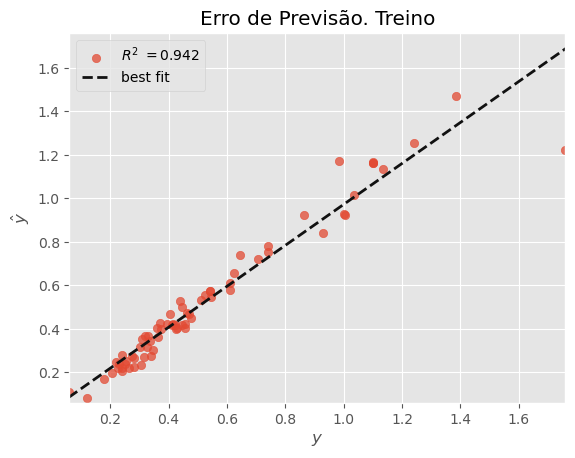

In [174]:
visualizer = PredictionError(model)
visualizer.score(X_train, y_train)
visualizer.title = "Erro de Previsão. Treino"
visualizer.shared_limits = False
visualizer.identity = False
visualizer.show();

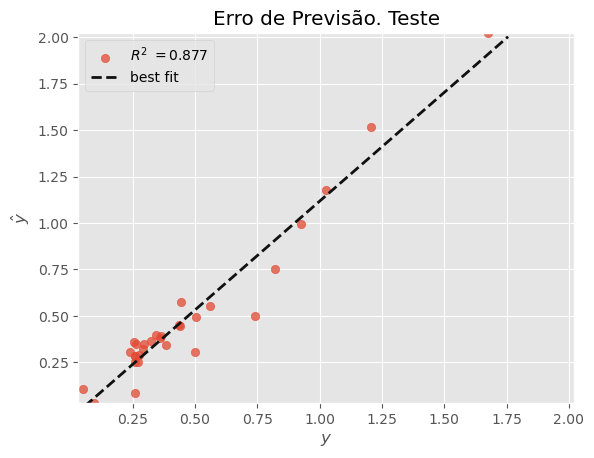

In [178]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)

visualizer.score(test_features, y_test)
visualizer.title = "Erro de Previsão. Teste"
visualizer.shared_limits = False
visualizer.identity = False
visualizer.show();

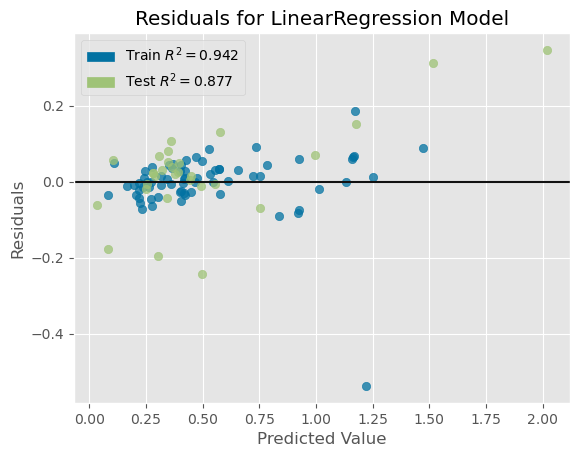

In [179]:
viz = residuals_plot(model, 
                     X_train, 
                     y_train, 
                     test_features, 
                     y_test,
                     hist=False)

viz.show()
plt.show();

In [108]:
y_pred =  model.predict(X_test)

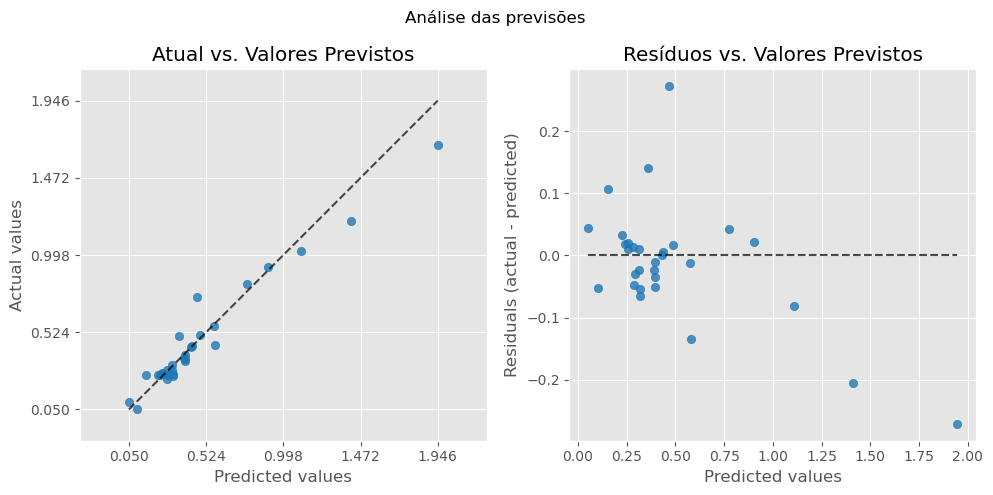

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("Atual vs. Valores Previstos")
    
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[0],
)


axs[1].set_title("Resíduos vs. Valores Previstos")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="residual_vs_predicted",
    subsample=1000,
    ax=axs[1],
)

fig.suptitle("Análise das previsões")
plt.tight_layout()
plt.show()